## SENTIMENT ANALYSIS: LLM-BASED APPROACH

In [2]:
!pip install flask
!pip install pyngrok
!pip install transformers
!pip install matplotlib seaborn pandas wordcloud
!pip install redis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 12.7 MB/s eta 0:00:00


## SERVER PER POLLING SU REDIS CLOUD

Connesso a Redis nel cloud con successo!
Consumatore avviato. Ricerca di chiavi JSON con pattern: reddit:json *, youtube:json*...

Trovate 10 chiavi JSON per il pattern 'reddit:json *' da elaborare.

Inizio elaborazione per: reddit_post_1kuqzkv da Reddit
Estratto testo Commento Reddit: '[The **Statistics** flair]( is reserved for posts highlighting interesting statistics. As a rule of ...'
Estratto testo Commento Reddit: 'All the more reason I hope he delays his opportunity at the Red Bull senior team as long as possible...'
Estratto testo Commento Reddit: 'And it is because of Lewis put back 3 spots. Funny that....'
Estratto testo Commento Reddit: 'He doesn’t get enough love. He’s really great....'
Estratto testo Commento Reddit: 'Hadjar has been great all season, and seems like a good kid too.  I wonder if him being the only Red...'
Estratto testo Commento Reddit: 'Isack is fast becoming a favourite of mine on the grid if not for the fact he fan boys over Lewis (m...'
Estratto testo 

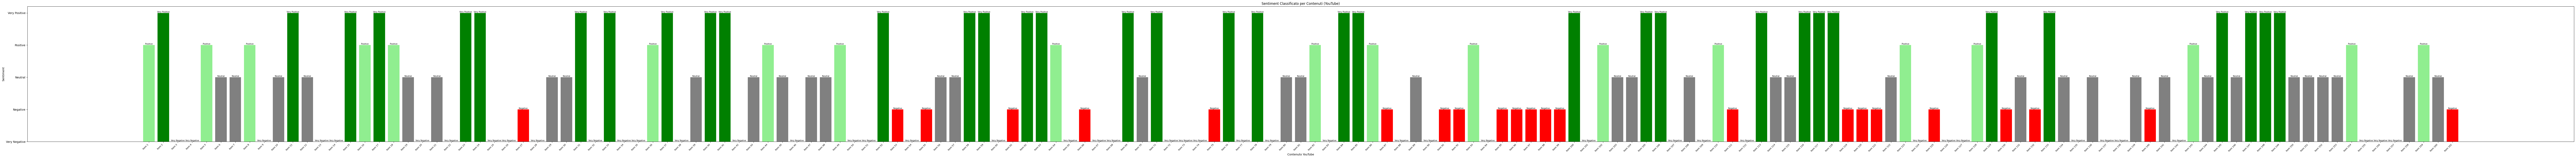

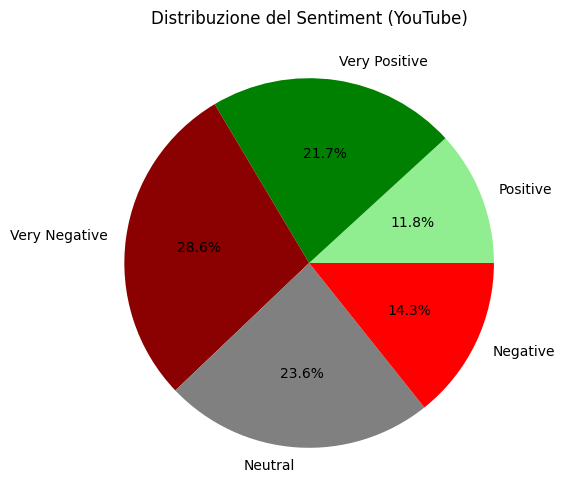

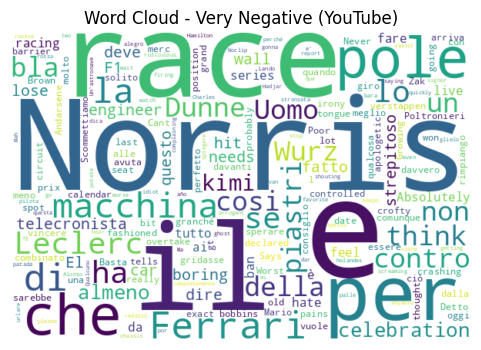

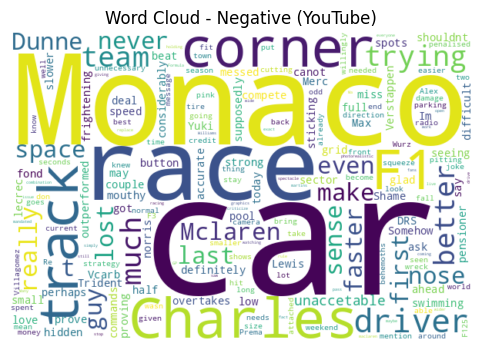

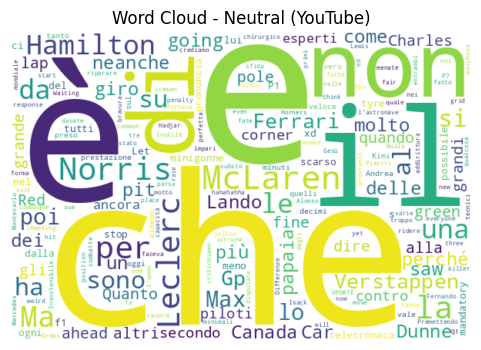

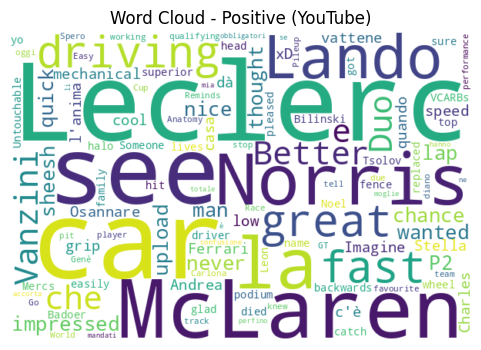

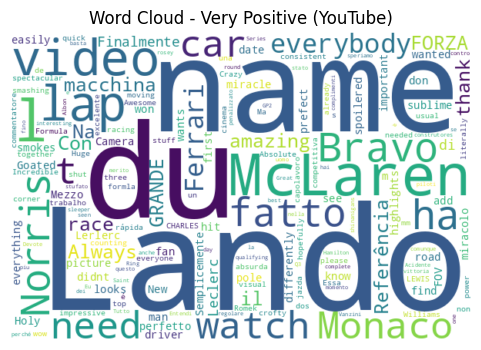


--- Riassunto Gemini per YouTube ---
Assolutamente! Ecco un'analisi dei grafici di sentiment che mi hai fornito:

**Riassunto Generale**

L'analisi del sentiment sui contenuti YouTube mostra un quadro misto. Mentre c'è una presenza significativa di sentiment positivi (molto positivo e positivo), una porzione notevole del sentiment è negativa (negativo e molto negativo). Questo indica che i contenuti generano reazioni sia positive che negative, con un peso verso quelle negative.

**Analisi Dettagliata**

*   **Tendenze Principali:**
    *   C'è una forte variabilità del sentiment nel tempo, come si vede nel grafico a barre. Periodi di feedback positivo intenso si alternano a periodi di negatività marcata.
    *   La distribuzione del sentiment mostra una predominanza del sentiment molto negativo (28.6%) e neutro (23.6%).
    *   Il sentiment positivo (positivo e molto positivo combinati) costituisce il 33.5%.

*   **Picchi e Anomalie:**
    *   Il grafico a barre rivela picchi frequent

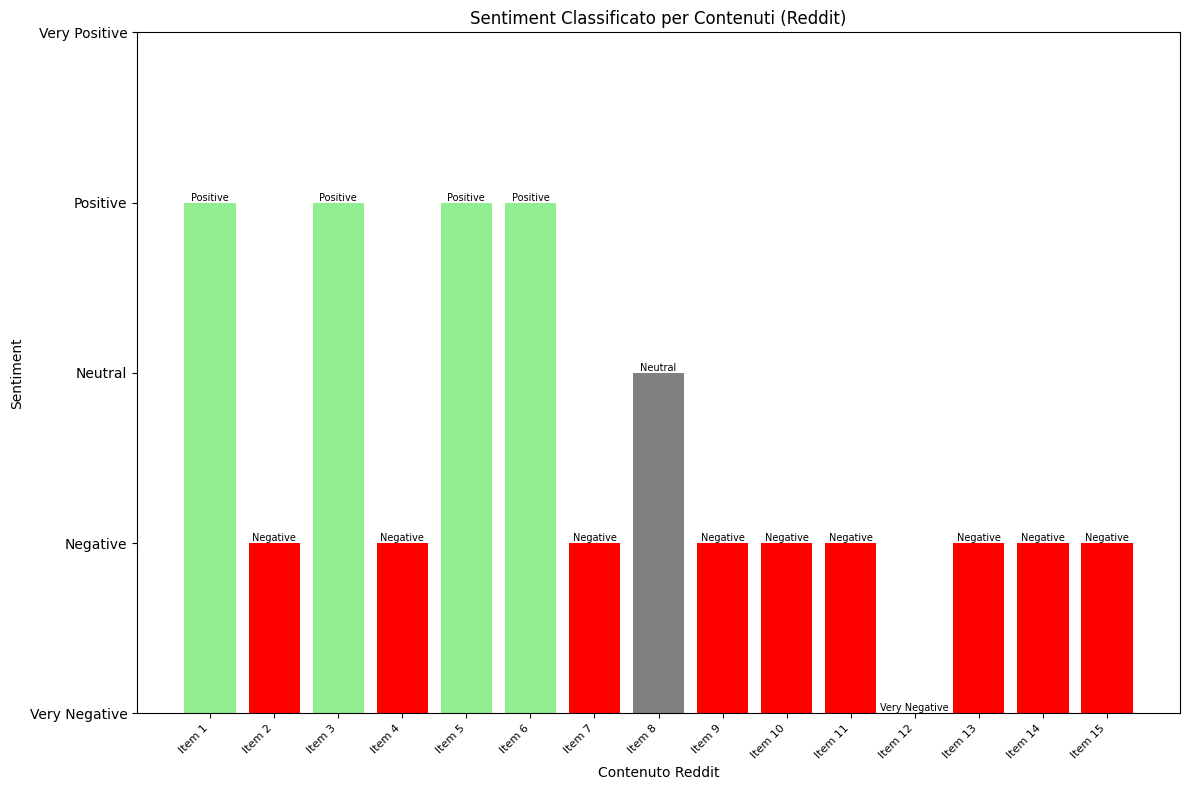

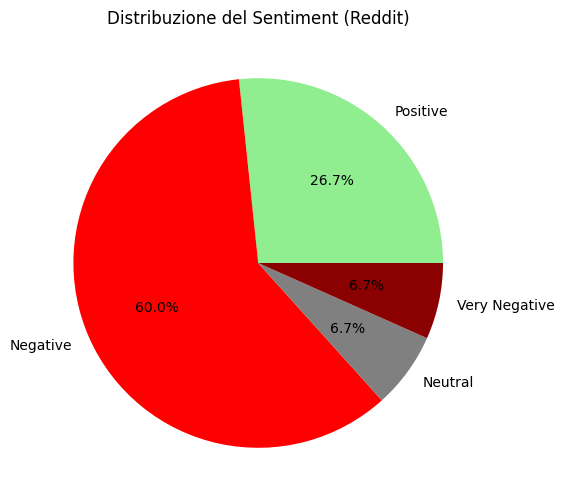

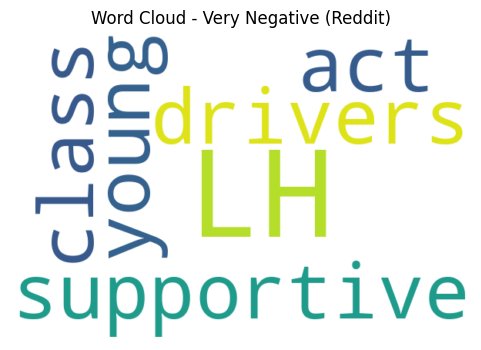

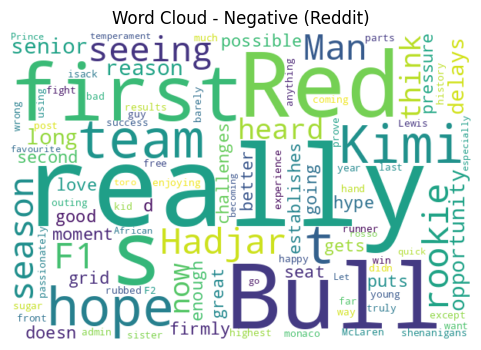

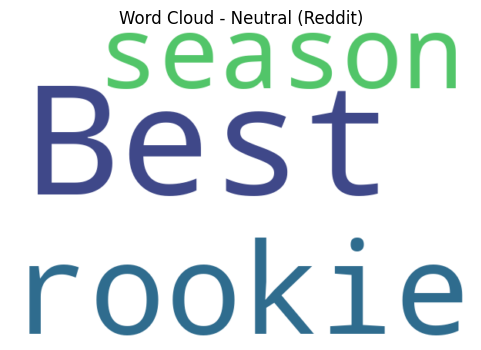

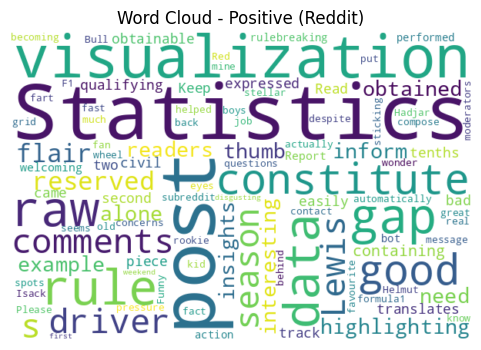


--- Riassunto Gemini per Reddit ---
Assolutamente! Ecco un'analisi dei dati di sentiment che mi hai fornito, con riassunto, insight e suggerimenti:

**Riassunto Generale**

L'analisi del sentiment sui contenuti Reddit mostra un orientamento prevalentemente negativo. La maggior parte dei contenuti analizzati (60%) esprime sentimenti negativi, mentre solo una piccola percentuale (26.7%) è positiva. Un numero limitato di contenuti risulta neutro (6.7%) o molto negativo (6.7%).

**Tendenze Principali, Picchi e Anomalie**

*   **Prevalenza del sentiment negativo:** La tendenza dominante è la presenza di un sentiment negativo nei commenti Reddit.
*   **Contenuti positivi concentrati:** I contenuti con sentiment positivo appaiono raggruppati in alcuni specifici "Item", suggerendo che determinati argomenti o discussioni suscitano reazioni più favorevoli rispetto ad altri.
*   **Picco di neutralità isolato:** C'è un singolo picco di sentiment neutro, che potrebbe indicare un contenuto informat

In [26]:
import requests, json, re
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from collections import Counter
import base64
import redis
import time
from google.colab import userdata
from redis.commands.json.path import Path
from wordcloud import WordCloud, STOPWORDS

# --- Configurazione Redis Cloud ---
REDIS_HOST = userdata.get('REDIS_HOST')
REDIS_PORT = int(userdata.get('REDIS_PORT'))
REDIS_USERNAME = userdata.get('REDIS_USERNAME')
REDIS_PASSWORD = userdata.get('REDIS_PASSWORD')

try:
    r = redis.Redis(
        host=REDIS_HOST,
        port=REDIS_PORT,
        username=REDIS_USERNAME,
        password=REDIS_PASSWORD,
        decode_responses=False
    )
    r.ping()
    print("Connesso a Redis nel cloud con successo!")
except redis.exceptions.ConnectionError as e:
    print(f"Errore di connessione a Redis: {e}")
    print("Assicurati che l'host, la porta e la password siano corretti e che il server Redis sia accessibile.")
    exit(1)

REDDIT_KEY_PATTERN = 'reddit:json *'
YOUTUBE_KEY_PATTERN = 'youtube:json*'
POLLING_KEY_PATTERNS = [REDDIT_KEY_PATTERN, YOUTUBE_KEY_PATTERN]
polling_interval_seconds = 300 #ogni 5 minuti il server prova a fetchare dati

### --- INIZIALIZZAZIONE MODELLO ---
api_key = userdata.get('GEMINI_API')

# Modello Hugging Face per YouTube
hf_model_name = "tabularisai/multilingual-sentiment-analysis"
hf_tokenizer = AutoTokenizer.from_pretrained(hf_model_name)
hf_model = AutoModelForSequenceClassification.from_pretrained(hf_model_name)

ordered_sentiments = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

def predict_sentiment_youtube(texts):
    """
    Prevede il sentiment per una lista di testi usando il modello Hugging Face.
    Utilizzato per i commenti di YouTube.
    """
    if not texts:
        print("TEXTS E' VUOTO")
        return []
    inputs = hf_tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = hf_model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_map = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}
    return [sentiment_map[p] for p in torch.argmax(probabilities, dim=-1).tolist()]

def predict_sentiment_gemini_for_reddit(text_to_analyze):
    """
    Prevede il sentiment per un singolo testo combinato (post+commenti) di Reddit usando Gemini.
    Tenta di ottenere un output standardizzato.
    """
    if not text_to_analyze or not text_to_analyze.strip():
        return "Neutral" # O un altro valore di default in caso di testo vuoto

    query = f"""Analizza il sentiment complessivo del seguente testo, che include un post di Reddit e i suoi commenti.
    Rispondi UNICAMENTE con una delle seguenti etichette, senza ulteriori spiegazioni o testo aggiuntivo:
    "Very Negative", "Negative", "Neutral", "Positive", "Very Positive".

    Testo da analizzare:
    {text_to_analyze}
    """

    try:
        res = requests.post(
            f"https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent?key={api_key}",
            headers={"Content-Type": "application/json"},
            data=json.dumps({"contents": [{"parts": [{"text": query}]}]})
        )
        res.raise_for_status()
        output = res.json()

        response_text = output.get('candidates', [{}])[0].get('content', {}).get('parts', [{}])[0].get('text', '').strip()

        for sentiment_label in ordered_sentiments:
            if sentiment_label in response_text:
                return sentiment_label

        print(f"Avviso: Gemini ha risposto inaspettatamente '{response_text}'. Assegnato 'Neutral'.")
        return "Neutral"

    except requests.exceptions.RequestException as e:
        print(f"Errore nella richiesta Gemini: {e}")
        return "Neutral"
    except json.JSONDecodeError as e:
        print(f"Errore nel parsing JSON della risposta Gemini: {e}")
        print(f"Risposta raw: {res.text if 'res' in locals() else 'N/A'}")
        return "Neutral"
    except Exception as e:
        print(f"Errore generico durante la previsione sentiment di Gemini: {e}")
        return "Neutral"

def generate_report(texts_for_wordcloud, sentiments_for_report, source_type="General"):
    """
    Genera report grafici (barre, torta, word clouds) per i testi e sentimenti forniti.
    `texts_for_wordcloud` è la lista di tutti i testi grezzi (per WC).
    `sentiments_for_report` è la lista dei sentimenti calcolati per ogni ITEM (per grafici a barre/torta).
    """
    if not sentiments_for_report: # Base il check sulla lista dei sentimenti, che è più diretta per i grafici
        print(f"Nessun dato di sentiment per generare il report {source_type}.")
        return

    # Per il grafico a barre, le etichette si basano sul numero di item analizzati
    labels = [f"Item {i+1}" for i in range(len(sentiments_for_report))]
    sentiment_to_index = {s: i for i, s in enumerate(ordered_sentiments)}
    y_values = [sentiment_to_index[s] for s in sentiments_for_report]

    # --- Grafico a barre dei sentimenti ---
    plt.figure(figsize=(max(10, len(sentiments_for_report) * 0.8), 8))
    colors = ["darkred", "red", "gray", "lightgreen", "green"]
    bar_colors = [colors[sentiment_to_index[s]] for s in sentiments_for_report]

    bars = plt.bar(labels, y_values, color=bar_colors)
    plt.yticks(ticks=range(len(ordered_sentiments)), labels=ordered_sentiments)
    plt.title(f"Sentiment Classificato per Contenuti ({source_type})")
    plt.ylabel("Sentiment")
    plt.xlabel(f"Contenuto {source_type}")
    plt.xticks(rotation=45, ha='right', fontsize=8)

    for bar, sentiment in zip(bars, sentiments_for_report):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), sentiment, ha='center', va='bottom', fontsize=7)

    plt.tight_layout()
    plt.savefig(f"sentiment_class_bar_chart_{source_type}.png")
    plt.show()
    plt.close()

    # --- Grafico a torta del sentiment ---
    sentiment_counts = Counter(sentiments_for_report)
    pie_colors = [colors[sentiment_to_index[s]] for s in sentiment_counts.keys()]

    plt.figure(figsize=(6, 6))
    plt.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', colors=pie_colors)
    plt.title(f"Distribuzione del Sentiment ({source_type})")
    plt.savefig(f"sentiment_pie_chart_{source_type}.png")
    plt.show()
    plt.close()

    # --- WordCloud per ogni sentimento ---
    # Qui usiamo i testi raw passati per la WordCloud
    for sentiment in ordered_sentiments:
        text_concat_for_wc = " ".join([t for t, s in zip(texts_for_wordcloud, sentiments_for_report) if s == sentiment])
        if not text_concat_for_wc.strip():
            continue
        wc = WordCloud(width=600, height=400, background_color='white', stopwords=set(STOPWORDS)).generate(text_concat_for_wc)
        plt.figure(figsize=(6, 4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud - {sentiment} ({source_type})")
        plt.savefig(f"wordcloud_{sentiment}_{source_type}.png")
        plt.show()
        plt.close()

def summarizationGemini(source_type="General"):
    """
    Contatta l'API di Gemini per riassumere i report grafici, specifici per source_type.
    """
    bar_chart_path = f"sentiment_class_bar_chart_{source_type}.png"
    pie_chart_path = f"sentiment_pie_chart_{source_type}.png"

    try:
        with open(bar_chart_path, "rb") as istogramma_sentiment:
            istogramma_sentiment_base64 = base64.b64encode(istogramma_sentiment.read()).decode('utf-8')
        with open(pie_chart_path, "rb") as torta_sentiment:
            torta_sentiment_base64 = base64.b64encode(torta_sentiment.read()).decode('utf-8')

        query = f"""
            Ti fornirò grafici di un'analisi del sentiment sui contenuti {source_type}.
            Analizza i grafici e produci un riassunto chiaro e sintetico che includa:
            - Tendenze principali, picchi o anomalie.
            - Proporzioni dei sentiment (molto negativo, negativo, neutro, positivo, molto positivo).
            - Insight interessanti o pattern ricorrenti.
            - Suggerimenti basati sui risultati per marketing o comunicazione.
            """
        res = requests.post(
            f"https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent?key={api_key}",
            headers={"Content-Type": "application/json"},
            data=json.dumps({"contents": [{"parts": [
                {"text": query},
                {"inline_data": {"mime_type": "image/png", "data": istogramma_sentiment_base64}},
                {"inline_data": {"mime_type": "image/png", "data": torta_sentiment_base64}}
            ]}]})
        )
        res.raise_for_status()
        output = res.json()
        response_extracted_words = output.get('candidates', [{}])[0].get('content', {}).get('parts', [{}])[0].get('text', '')
        res_new = response_extracted_words.replace("```json", "").replace("```", "")
        print(f"\n--- Riassunto Gemini per {source_type} ---")
        print(res_new)
        print(f"--- Fine Riassunto Gemini per {source_type} ---\n")
    except FileNotFoundError:
        print(f"Errore: File grafici non trovati per {source_type}. Assicurati che i report siano stati generati prima di chiamare Gemini.")
    except requests.exceptions.RequestException as e:
        print(f"Errore nella richiesta Gemini per la summarization: {e}")
    except json.JSONDecodeError as e:
        print(f"Errore nel parsing JSON della risposta Gemini per la summarization: {e}")
    except Exception as e:
        print(f"Errore generico durante la summarization Gemini per {source_type}: {e}")

def process_message(message_data):
    """
    Elabora un singolo messaggio da Redis e restituisce il testo combinato/originale,
    il sentiment calcolato e la lista di testi raw per le WordCloud.
    """
    content_id = message_data.get('content_id', 'Unknown ID')
    social_media_type = message_data.get('social_media', 'Unknown')
    print(f"\nInizio elaborazione per: {content_id} da {social_media_type}")

    combined_text_for_sentiment = ""
    texts_for_wordcloud_current_item = [] # Raccoglie tutti i testi grezzi per la WordCloud di questo specifico item

    if social_media_type == 'YouTube':
        comment_text = message_data.get('comment_raw_text', '')
        if comment_text.strip():
            combined_text_for_sentiment = comment_text # Per YouTube, il testo combinato è il commento stesso
            texts_for_wordcloud_current_item.append(comment_text)
            print(f"Estratto testo YouTube: '{comment_text[:100]}...'")
        else:
            print(f"Nessun testo valido trovato per il commento YouTube {content_id}.")
            return None, None, None

        # Sentiment per YouTube (Hugging Face)
        sentiment_result = predict_sentiment_youtube([combined_text_for_sentiment])[0]

    elif social_media_type == 'Reddit':
        post_text = message_data.get('comment_raw_text', '')
        if post_text.strip():
            combined_text_for_sentiment += post_text
            texts_for_wordcloud_current_item.append(post_text)
            print(f"Estratto testo Post Reddit: '{post_text[:100]}...'")

        comments = message_data.get('comments', [])
        for comment in comments:
            comment_text = comment.get('comment_raw_text', '')
            if comment_text.strip():
                combined_text_for_sentiment += " commento:" + comment_text # Aggiungi " commento:" come separatore
                texts_for_wordcloud_current_item.append(comment_text)
                print(f"Estratto testo Commento Reddit: '{comment_text[:100]}...'")

        if not combined_text_for_sentiment.strip():
            print(f"Nessun testo valido (post o commenti) trovato per l'elemento Reddit {content_id}.")
            return None, None, None
        print(f"Testo combinato Reddit (post+commenti): '{combined_text_for_sentiment[:200]}...'")

        # Sentiment per Reddit (Gemini)
        sentiment_result = predict_sentiment_gemini_for_reddit(combined_text_for_sentiment)

    else:
        print(f"Tipo di social media '{social_media_type}' non riconosciuto per {content_id}.")
        return None, None, None

    return combined_text_for_sentiment, sentiment_result, texts_for_wordcloud_current_item


if __name__ == "__main__":
    print(f"Consumatore avviato. Ricerca di chiavi JSON con pattern: {', '.join(POLLING_KEY_PATTERNS)}...")

    # Liste per accumulare i risultati per la generazione dei report finali
    # Questi sono i testi su cui è stato calcolato il sentiment (commento YouTube o post+commenti Reddit)
    final_youtube_sentiments_data = [] # Lista di sentimenti per YouTube
    final_reddit_sentiments_data = [] # Lista di sentimenti per Reddit

    # Liste per accumulare tutti i testi RAW per le WordCloud
    all_youtube_raw_texts_for_wc = []
    all_reddit_raw_texts_for_wc = []

    try:
        while True:
            total_processed_keys_in_cycle = 0
            for pattern in POLLING_KEY_PATTERNS:
                cursor = 0
                keys_to_process = []
                while True:
                    cursor, keys = r.scan(cursor, match=pattern, count=50)
                    keys_to_process.extend(keys)
                    if cursor == 0:
                        break
                if keys_to_process:
                    print(f"\nTrovate {len(keys_to_process)} chiavi JSON per il pattern '{pattern}' da elaborare.")
                    for key_bytes in keys_to_process:
                        key = key_bytes.decode('utf-8')
                        try:
                            message_data = r.json().get(key, Path.root_path())

                            if message_data:
                                # Processa il singolo elemento e ottieni il testo combinato/originale,
                                # il suo sentiment e i testi raw per la WordCloud
                                combined_text, sentiment_val, raw_texts_for_wc_current_item = process_message(message_data)

                                if combined_text is not None and sentiment_val is not None:
                                    social_media_type = message_data.get('social_media', 'Unknown')
                                    if social_media_type == "YouTube":
                                        final_youtube_sentiments_data.append(sentiment_val)
                                        all_youtube_raw_texts_for_wc.extend(raw_texts_for_wc_current_item)
                                    elif social_media_type == "Reddit":
                                        final_reddit_sentiments_data.append(sentiment_val)
                                        all_reddit_raw_texts_for_wc.extend(raw_texts_for_wc_current_item)

                                    r.delete(key)
                                    total_processed_keys_in_cycle += 1
                                    print(f"Chiave '{key}' eliminata dopo l'elaborazione.")
                                else:
                                    print(f"Nessun dato valido estratto o sentiment calcolato per la chiave '{key}'. Non eliminata.")

                            else:
                                print(f"Chiave '{key}' non trovata o vuota durante il GET.")

                        except json.JSONDecodeError:
                            print(f"Errore nel parsing JSON per la chiave '{key}'. Contenuto non valido. Chiave non eliminata.")
                        except Exception as e:
                            print(f"Errore durante l'elaborazione o eliminazione della chiave '{key}': {e}. Chiave non eliminata.")
                else:
                    print(f"Nessuna chiave con pattern '{pattern}' trovata in questo ciclo.")

            if total_processed_keys_in_cycle == 0:
                print(f"Nessun nuovo messaggio elaborato in questo ciclo. Pausa di {polling_interval_seconds} secondi...")
                time.sleep(polling_interval_seconds)
            else:
                print(f"\nCiclo completato. Elaborati {total_processed_keys_in_cycle} messaggi totali.")

    except KeyboardInterrupt:
        print("\nConsumatore interrotto dall'utente.")
        print("\nGenerazione dei report finali...")

        # --- Generazione Report e Summarization per YouTube ---
        if final_youtube_sentiments_data:
            print("\nGenerazione report finale e summarization per Youtube...")
            generate_report(all_youtube_raw_texts_for_wc, final_youtube_sentiments_data, "YouTube")
            summarizationGemini("YouTube")
        else:
            print("Nessun dato YouTube elaborato per generare il report finale.")

        # --- Generazione Report e Summarization per Reddit ---
        if final_reddit_sentiments_data:
            print("\nGenerazione report finale e summarization per Reddit...")
            generate_report(all_reddit_raw_texts_for_wc, final_reddit_sentiments_data, "Reddit")
            summarizationGemini("Reddit")
        else:
            print("Nessun dato Reddit elaborato per generare il report finale.")

    except Exception as e:
        print(f"Errore inaspettato: {e}")
    finally:
        print("Consumatore terminato.")